# The battle of neighborhoods  - Applied Data Science Capstone by IBM/Coursera #


### INTRODUCTION ###

The main objective of the project is to find out the most visited venues in the cities of India with moderate population, high migrated population and clustering them according to the venues. 

If a person wants to moigrate to India to a city where there is moderate population and also if desires to start a restaurant, this project drives the person to meet his goals.
Inorder to aid the person we first takes the data of cities of India, 
This data drives the business person who is interested in opening a new food restaurant in a city of India. This projects helps the person to understand the most visited restaurant/cafe in the given cities of India by further helping in to choose the place and cuisine of the restaurant he wants to start.  

### DataSet Description###

#### Link : The dataset is downloaded from https://simplemaps.com/data/in-cities

the features are 

1. Name of the city 

2. Cordinates - Lattitude & Longitude 

3. Country - Coubtry name 

4. City - City Name 

5. Admin - If the place is capital ?

6. Population - over all population includes migrated population
 
7. Population_proper - native people 

8. iso - india code 

**1.Importing required Libraries and packages**

In [855]:
import pandas as pd 
import matplotlib.pyplot as plt
import random 
import requests
from geopy.geocoders import Nominatim 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
from geopy.extra.rate_limiter import RateLimiter
import folium 
from collections import Counter 



print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [865]:
#getting the data from the url 
url ='https://raw.githubusercontent.com/deepthi248/DataScienceCapstone/master/Indian_Data%20.csv'
India_df = pd.read_csv(url)
India_df.head()

,city,lat,lng,country,iso2,admin,capital,population,population_proper
0,Mumbai,18.987807,72.836447,India,IN,Mahārāshtra,admin,18978000.0,12691836.0
1,Delhi,28.651952,77.231495,India,IN,Delhi,admin,15926000.0,7633213.0
2,Kolkata,22.562627,88.363044,India,IN,West Bengal,admin,14787000.0,4631392.0
3,Chennai,13.084622,80.248357,India,IN,Tamil Nādu,admin,7163000.0,4328063.0
4,Bengalūru,12.977063,77.587106,India,IN,Karnātaka,admin,6787000.0,5104047.0


In [857]:
#adding missing data of dataset 
India_df.loc[207,'population'] = 432000.00
India_df.loc[208,'population'] = 66293.00
India_df.loc[209,'population'] = 3812000.00
India_df.loc[210,'population'] = 292000.00
India_df.loc[211,'population'] = 211000.00
India_df.loc[207,'population_proper'] = 292000.00
India_df.loc[208,'population_proper'] = 66293.00
India_df.loc[209,'population_proper'] = 2508689.00
India_df.loc[210,'population_proper'] = 292000.00
India_df.loc[211,'population_proper'] = 211000.00



**DATA PREPROCESSING**

In [858]:

#creating temp df to work on
df_India = India_df.copy()

#renaming column names 
df_India = df_India.rename(columns={'admin': 'state','lat':'lattitude','lng':'longitude'}, index={'ONE': 'one'})

#dropping unecessary columns 
df_India= df_India.drop(columns= ['iso2'])

# dealing with nan values 
df_India['capital'].isnull().any()

# replacing nan values with 'Non_Capital'
df_India=df_India.fillna(value='Non_Capital')

In [859]:
#label Encoding the column capital 
from sklearn.preprocessing import LabelEncoder 
Le = LabelEncoder()
df_India['capital']= Le.fit_transform(df_India['capital']) 
df_India[df_India['capital']== 3] #checking if the data is for the city Delhi 
# 0 - Non_capital ; 1- Capital, 2- minor cities ;3- India's capital 

#getting migrated population
df_India['population_migrated'] = df_India['population'] - df_India['population_proper']


#creating location column for geopy functions
df_India['Location']= df_India['city']+','+df_India['state']+','+df_India['country']


#sorting df according to population
df_India = df_India.sort_values(by =['population'],ascending=True)
df_India

#getting data types of the columns
df_India.dtypes


print(df_India.shape)

(212, 10)


As per my objective 
1. I want to move to a place where the population is moderate.
2. I want to start a business in the place where the migrating population is high which shows the growth of development of particular city

In [860]:
#getting quartile data for population distribution for 
arr = np.percentile(df_India.population, [20, 50, 80])


#getting the data of cities with above mentioned population raange 
processed_df =  df_India[(df_India['population'] >= arr[0]) & (df_India['population'] <= arr[2])]

#Understanding the data 
processed_df['capital'].value_counts() 
#there are 131 non capital, 2 minor cities, India Capital and 14 capital cities with in that population range 

# Now filtering data according to the migrated population 
processed_df.sort_values(['population_migrated'])

(processed_df['population_migrated'] == 0 ).value_counts() 
#there are 54 cities which has 0 migrated population

#droping those 54 migrated population 
processed_df.drop(processed_df[(processed_df['population_migrated'] == 0) ].index, inplace = True) 
    
print(processed_df.shape)

# there are total 94 cities where there is population migration 
processed_df['population_migrated'].value_counts() 

processed_df[processed_df['population_migrated']<0] #getting the data of cities which has -ve population migration 
processed_df.drop(index=72,inplace=True )#removing the data with the index 


/Users/deepthi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(79, 10)


In [861]:
#print(processed_df.shape) # final data 
processed_df.head()

,city,lattitude,longitude,country,state,capital,population,population_proper,population_migrated,Location
164,Tonk,26.168672,75.786111,India,Rājasthān,0,181734.0,151331.0,30403.0,"Tonk,Rājasthān,India"
162,Bhusāval,21.043649,75.785058,India,Mahārāshtra,0,183001.0,172366.0,10635.0,"Bhusāval,Mahārāshtra,India"
161,Nandyāl,15.477994,78.483605,India,Andhra Pradesh,0,188654.0,165337.0,23317.0,"Nandyāl,Andhra Pradesh,India"
156,Proddatūr,14.750200,78.548129,India,Andhra Pradesh,0,197451.0,177797.0,19654.0,"Proddatūr,Andhra Pradesh,India"
150,Ongole,15.503565,80.044541,India,Andhra Pradesh,0,202860.0,172872.0,29988.0,"Ongole,Andhra Pradesh,India"


In [862]:
data = processed_df.groupby('state').sum()[['population_migrated']].sort_values(by ='population_migrated')
data['population_migrated'] =data['population_migrated']/1000


data1=data.copy()
data1.drop(data1[(data1['population_migrated'] < data.population_migrated.median())].index ,inplace = True) 
# naa final states - data1 lo unnay - ippudu nenu overall data lonchi ee states kanivi peekeyyali 


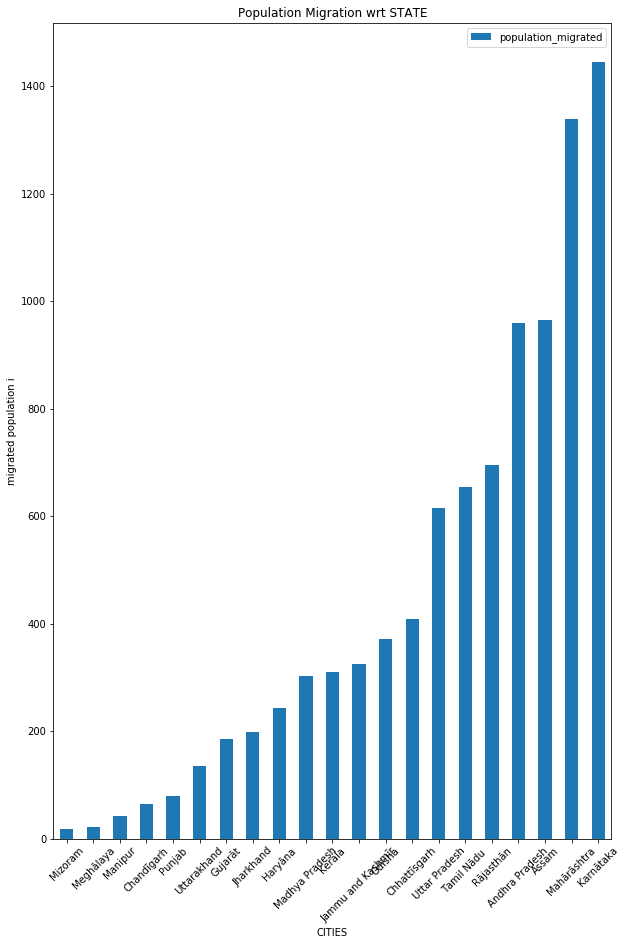

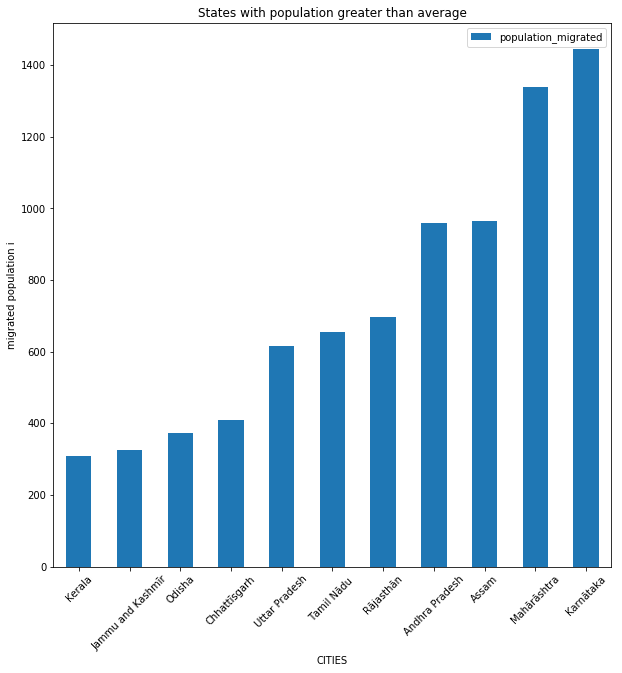

In [863]:
# Visualising the data final data 
ax1=data.plot(kind='bar', figsize=(10, 15), rot=0)
ax1.set_ylabel('migrated population i') # add to x-label to the plot
ax1.set_xlabel('CITIES') # add y-label to the plot
ax1.set_title('Population Migration wrt STATE') # add title to the plot

plt.xticks(rotation=45)
plt.show()

ax2=data1.plot(kind='bar', figsize=(10, 10), rot=0)
ax2.set_ylabel('migrated population i') # add to x-label to the plot
ax2.set_xlabel('CITIES')
ax2.set_title('States with population greater than average') # add title to the plot
plt.xticks(rotation=45)
plt.show()

In [866]:
data1.rest_index(inplace=True)
required_states = data1['state'].tolist()

AttributeError: 'DataFrame' object has no attribute 'rest_index'

In [ ]:
required_states

1. The migrated population is highest in Maharastra followed by Andhra Pradesh.
2. Let us filter the data by taking the cities in the states greater than the average migrated population in second barplot 2

In [ ]:
for i in required_states:
    final_df =final_data.append(processed_df[processed_df['state']==i])
final_df

**getting all the venues of cities from foursquare** 


In [ ]:
#credentials of foursquare
CLIENT_ID = 'EUJJS25FPTDTU50RKSGJMPMCXOWSRYFT1ZKRZ53PJRVL2OO3' # your Foursquare ID
CLIENT_SECRET = '10HHSTUOSHCRHHNEBRZQJ3JBNWLV1JFWBIBIOWCUZN4R40CO' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


In [ ]:
#this function helps to pullout all the near by venues in the given city according to latitude,longitude and name 


def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    all_venues=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # get request 
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        all_venues.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        
        
        
        
        nearby_venues = pd.DataFrame([item for all_venues in all_venues for item in all_venues])
    nearby_venues.columns = ['city', 
                  'city Latitude', 
                  'city Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
city_venues = getNearbyVenues(names=final_df['city'],
                                   latitudes=final_df['lattitude'],
                                   longitudes=final_df['longitude'],
                                  )

In [869]:
city_venues.to_csv('cityVenues.csv')
city_venues.head()
city_venues.shape

(1628, 7)

In [ ]:
city_venues['Venue Category'].unique()
city_venues.groupby('city').count()


In [ ]:
# Inorer to deal with the categorical data for clustering - One Hot Encoding 
onehot_df = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")
onehot_df.head()

# adding the city column to the data frame
onehot_df['city'] = city_venues['city'] 

#moving city  to column1 
fixed_columns = [onehot_df.columns[-1]] +( onehot_df.columns[:-1]).tolist()
onehot_df = onehot_df[fixed_columns]

In [ ]:
print(onehot_df.shape)
onehot_df.head()

In [ ]:
#grouping the data city wise 
grouped_cities = onehot_df.groupby(["city"]).mean().reset_index()

print(grouped_cities.shape)
grouped_cities


In [ ]:
#function that returns the most common venues in the city 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['city'] =grouped_cities ['city']

for ind in np.arange(grouped_cities.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_cities.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

In [ ]:
from sklearn.cluster import KMeans

# setting the number of clusters
clusters = 5

grouped_clustering = grouped_cities.drop('city', 1)

# Kmeans clustering -training
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [ ]:
# dropping NaN values 
city_venues_sorted.dropna(inplace = True)


In [ ]:
#inserting the cluster labels column to the dataframe
city_venues_sorted.insert(9, 'Cluster Labels', kmeans.labels_)
merged_city_df = city_venues

# merging the venues data with the city wise data
merged_city_df = pd.merge(city_venues, city_venues_sorted, on='city')

merged_city_df.head() 

In [ ]:
#changing the cluster labels data type to int 
merged_city_df['Cluster Labels'] = merged_city_df['Cluster Labels'].astype(int)


In [867]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_city_df['city Latitude'], merged_city_df['city Longitude'], merged_city_df['city'], merged_city_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

KeyboardInterrupt: 

In [ ]:
merged_city_df[merged_city_df['Cluster Labels'] == 0]

#vegetarian restauranta +hotels + historic sites + zoo+ mountain +train and bus 

In [ ]:
merged_city_df[merged_city_df['Cluster Labels'] == 1]
# concentrated on shopping malls + zoo+ chicken/French 

In [ ]:
merged_city_df[merged_city_df['Cluster Labels'] == 2]
#icecream shops+ bus + train + food shops 

In [ ]:
merged_city_df[merged_city_df['Cluster Labels'] == 3]

# concentrated on cafe + park +food courts +lake +hotels 

In [ ]:
merged_city_df[merged_city_df['Cluster Labels'] == 4]

# concentrated on food cafes and indian & french restaurants and have train and bus facilities with historic places 


## Conslusion

**A business man can go through the clustered locations and pick a location which can satisfy his business requirments. **

**For Example: If that person wants to open a vegetarian restaurant he can choose a location from cluster 0 